<a href="https://colab.research.google.com/github/Daivar/Deep_dreaming/blob/main/Deep_dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3


base_image_path = keras.utils.get_file("forest.jpg", 'https://www.wallpapertip.com/wmimgs/166-1665019_deer-and-forest-beautiful-spring-nature-wallpaper-wallpaper.jpg')
result_prefix = "doggo_dream"

1843200/1827604 [==============================] - 0s 0us/step


In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))

In [86]:
step = 0.05 # 0.05 # Gradient ascent step size (the learning rate, aka the multiplyier for the gradients)
num_octave = 0  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 100 # 150 # Number of ascent steps per scale
max_loss = 100.0 # Limit the loss as it result in images that look damaged

In [87]:
# These are the names of the layers for which we try to maximize activation,
# as well as their weight in the final loss we try to maximize.
# You can tweak these setting to obtain new visual effects.
layer_settings = {
   # "mixed0": 0.1,
    # "mixed1": 0.1,
    # "mixed2": 0.1,
    "mixed3": 1.0,
     # "mixed4": 0.1,
     "mixed5": 10.0,
     # "mixed6": 2.0,
      "mixed7": 9.5,
     # "mixed8": 3.0,
     "mixed9": 25.0,

  }  

In [88]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate arrays.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    # Util function to convert a NumPy array into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Undo inception v3 preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [89]:
# Build an InceptionV3 model loaded with pre-trained ImageNet weights
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)
# model.summary()

In [ ]:
model.summary()

In [90]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

outputs_dict

{'mixed3': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 'mixed5': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>,
 'mixed7': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed7')>,
 'mixed9': <KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'mixed9')>}

In [91]:
model.inputs

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_7')>]

In [92]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
feature_extractor.summary()

In [94]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling # avoid border artifacts by only involving non-border pixels in the loss.
        # loss += coeff * tf.reduce_sum(tf.square(activation)) / scaling # avoid border artifacts by only involving non-border pixels in the loss.
    return loss

In [95]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients for regularization
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    # we transform our image add adding calcualted gradients
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

In [96]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

# ...generating shapes for rescaling
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

In [97]:
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0]) # decrease by image by 40% x 2

In [98]:
img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img # <----
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (1200, 2000)
... Loss value at step 0: 2.74
... Loss value at step 1: 3.38
... Loss value at step 2: 4.11
... Loss value at step 3: 4.27
... Loss value at step 4: 4.96
... Loss value at step 5: 5.28
... Loss value at step 6: 5.84
... Loss value at step 7: 6.39
... Loss value at step 8: 6.93
... Loss value at step 9: 7.41
... Loss value at step 10: 8.09
... Loss value at step 11: 8.50
... Loss value at step 12: 9.40
... Loss value at step 13: 10.13
... Loss value at step 14: 10.61
... Loss value at step 15: 11.73
... Loss value at step 16: 12.04
... Loss value at step 17: 12.97
... Loss value at step 18: 13.91
... Loss value at step 19: 15.09
... Loss value at step 20: 15.77
... Loss value at step 21: 16.72
... Loss value at step 22: 18.02
... Loss value at step 23: 18.61
... Loss value at step 24: 20.25
... Loss value at step 25: 21.18
... Loss value at step 26: 22.64
... Loss value at step 27: 23.61
... Loss value at step 28: 25.07
... Loss value at step

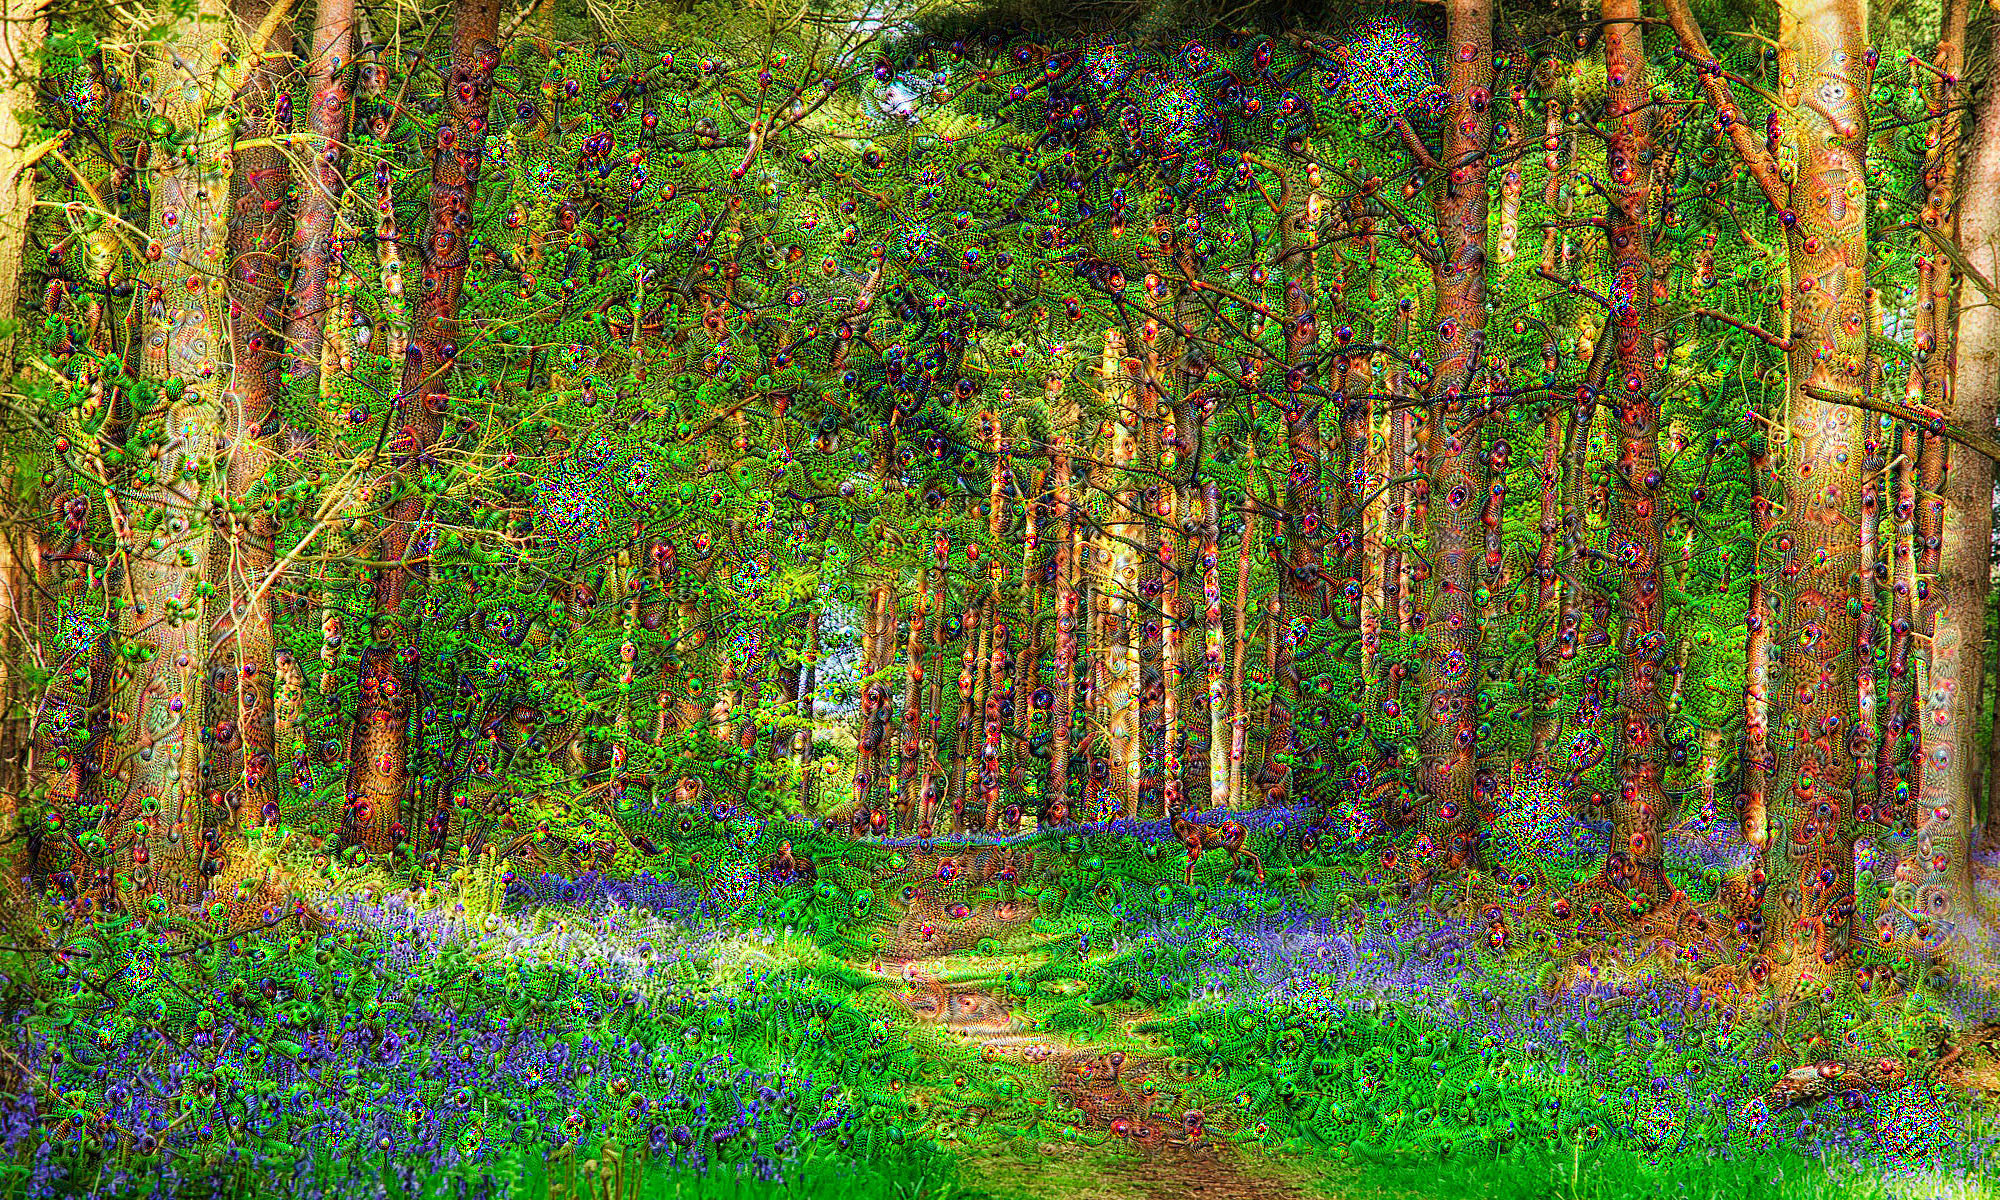

In [23]:
display(Image(result_prefix + ".png"))